# Setup runtime

In [1]:
# TO BE DELETED

import sys

sys.path.append("src")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils

# Read data
In this section we read raw data to the memory. As the dataset is already split into train and test set, we perform the analysis using only train set. Therefore, we prevent information leakage.

In [6]:
directory = "./data/train"
files = os.listdir(directory)
data = dict()
for f in files:
    raw_df = pd.read_csv(os.path.join(directory, f))
    data[f] = {
        "trial number": int(raw_df["trial number"].unique()[0]),
        "name": raw_df["name"].unique()[0],
        "time_series": utils.get_ts_from_df(raw_df),
        "matching condition": raw_df["matching condition"].unique()[0].rstrip(","),
        "subject identifier": raw_df["subject identifier"].unique()[0],
    }

The names proposed by the authors of the dataset are not accurate. Thus, we rename variables for further convenience.

In [16]:
key_names = {
    "trial number": "id",
    "name": "subject",
    "time_series": "ts",
    "matching condition": "condition",
    "subject identifier": "class"
}
data = {f: {key_names[k]: v for k, v in d.items()} for f, d in data.items()}

# EDA

## Is the dataset balanced?

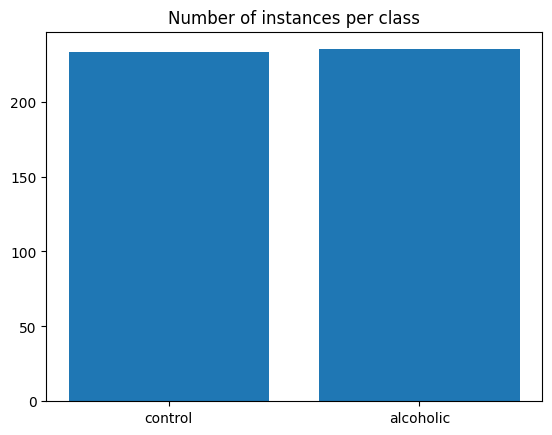

alcoholic: 235, control: 233


In [148]:
classes = [1 if d["class"] == "a" else 0 for d in data.values()]
plt.set_cmap(plt.cm.Pastel1)
plt.hist(classes, bins=[-0.4, 0.4, 0.6, 1.4])
plt.xticks((0, 1), ("control", "alcoholic"))
plt.title("Number of instances per class")
plt.show()
print(f"alcoholic: {sum(classes)}, control: {len(classes) - sum(classes)}")

## How the distribution of condition objects over classes looks like?

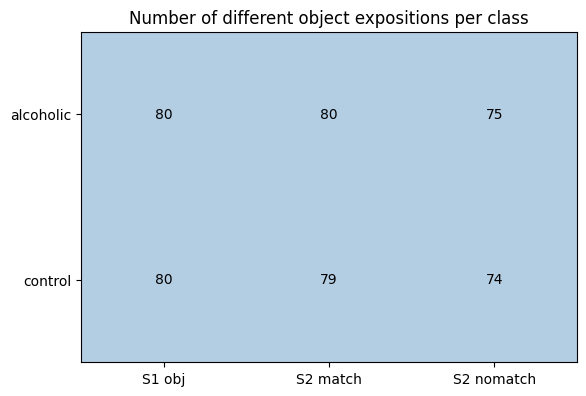

In [213]:
condition_distribution = {
    "a": {"S1 obj": 0, "S2 match": 0, "S2 nomatch": 0},
    "c": {"S1 obj": 0, "S2 match": 0, "S2 nomatch": 0}
}

for d in data.values():
    condition_distribution[d["class"]][d["condition"]] += 1
condition_distribution_map = [list(cd.values()) for cd in condition_distribution.values()]
plt.imshow(condition_distribution_map, vmin=0, vmax=len(data))
plt.xticks(range(len(condition_distribution["a"])), labels=condition_distribution["a"].keys())
plt.yticks(range(len(condition_distribution)), labels=["alcoholic", "control"])
for cl_i, cls in enumerate(condition_distribution.keys()):
    for co_i, condition in enumerate(condition_distribution["a"].keys()):
        text = plt.text(co_i, cl_i, condition_distribution[cls][condition], ha="center", va="center")
plt.title("Number of different object expositions per class")
plt.show()

## How the time series look like? What are their statistics?

In [80]:
rows, cols = len(data), data["Data1.csv"]["ts"].shape[1]
mean_, max_, min_ = np.empty((rows, cols)), np.empty((rows, cols)), np.empty((rows, cols))

for i_d, d in enumerate(data.values()):
    ts = d["ts"].to_numpy()
    mean_[i_d] = ts.mean(axis=0)
    max_[i_d] = ts.max(axis=0)
    min_[i_d] = ts.min(axis=0)

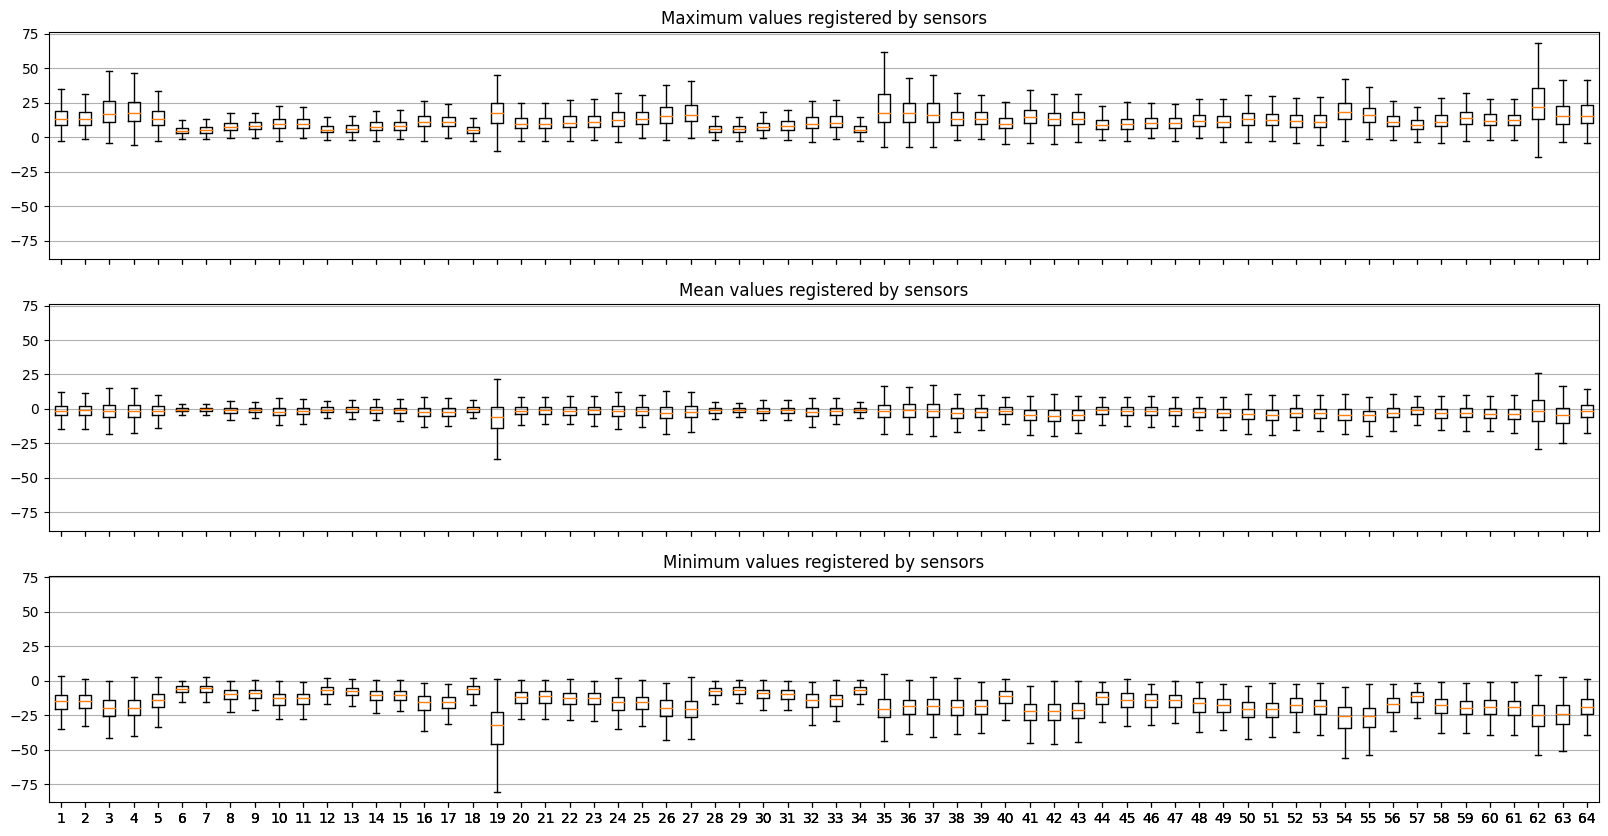

In [133]:
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(20, 10))

for ax in axs:
    ax.grid(axis="y")
axs[0].boxplot(max_, showfliers=False)
axs[0].set_title("Maximum values registered by sensors")
axs[1].boxplot(mean_, showfliers=False)
axs[1].set_title("Mean values registered by sensors")
axs[2].boxplot(min_, showfliers=False)
axs[2].set_title("Minimum values registered by sensors")
plt.show()

# Can we observe any correlation between aforementioned statistics and target variable (class)?

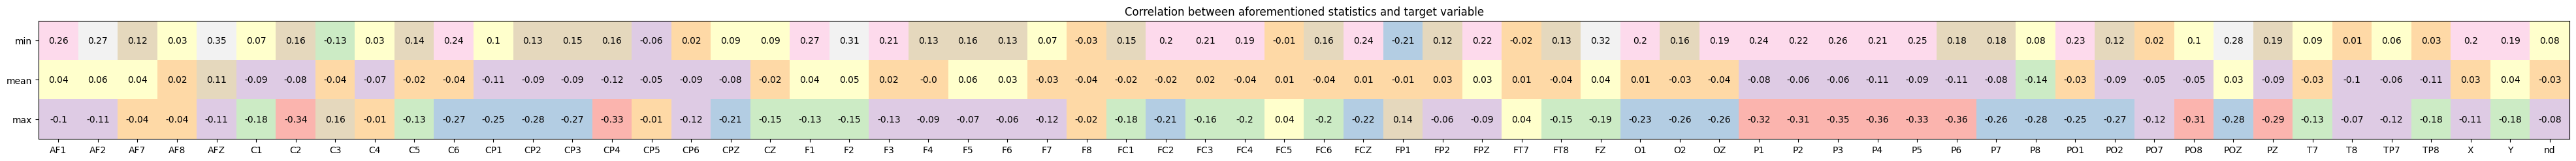

In [232]:
from scipy.stats import pearsonr

corr = np.empty((len(min_.transpose()), 3))

for i_s, stat in enumerate((min_, mean_, max_)):
    for i_m, m in enumerate(stat.transpose()):
        corr[i_m, i_s] = pearsonr(m, classes)[0]

plt.figure(figsize=(50, 5))
plt.imshow(corr.transpose())
plt.xticks(range(corr.shape[0]), labels=data["Data1.csv"]["ts"].columns)
plt.yticks(range(corr.shape[1]), labels=["min", "mean", "max"])
for x in range(corr.shape[0]):
    for y in range(corr.shape[1]):
        text = plt.text(x, y, np.round(corr[x, y], 2), ha="center", va="center")
plt.title("Correlation between aforementioned statistics and target variable")
plt.show()

## Are the time series stationary?

/home/jkarolczak/miniconda3/envs/eeg-alcoholics/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/jkarolczak/miniconda3/envs/eeg-alcoholics/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/jkarolczak/miniconda3/envs/eeg-alcoholics/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/jkarolczak/miniconda3/envs/eeg-alcoholics/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/jkarolczak/miniconda3/envs/eeg-alcoholics/lib/

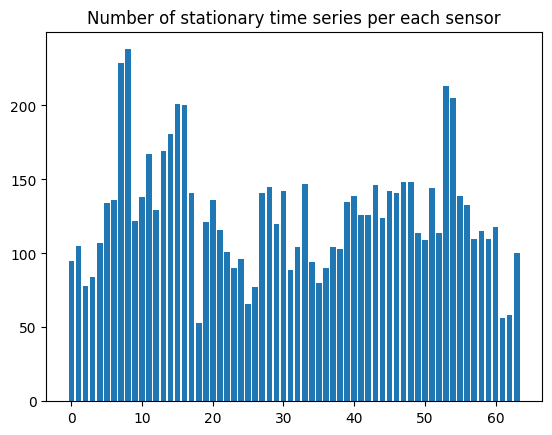

In [177]:
from statsmodels.tsa.stattools import adfuller

stationary_ts = np.zeros(data["Data1.csv"]["ts"].shape[1], dtype=int)

for d in data.values():
    for i_c, col in enumerate(d["ts"].columns):
        stationary_ts[i_c] += int(adfuller(d["ts"][col])[1] < 0.05)
plt.bar(range(len(stationary_ts)), stationary_ts)
plt.title("Number of stationary time series per each sensor")
plt.show()

## Can we easily fix time series to make them stationary?

/home/jkarolczak/miniconda3/envs/eeg-alcoholics/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/jkarolczak/miniconda3/envs/eeg-alcoholics/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/jkarolczak/miniconda3/envs/eeg-alcoholics/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/jkarolczak/miniconda3/envs/eeg-alcoholics/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/home/jkarolczak/miniconda3/envs/eeg-alcoholics/lib/

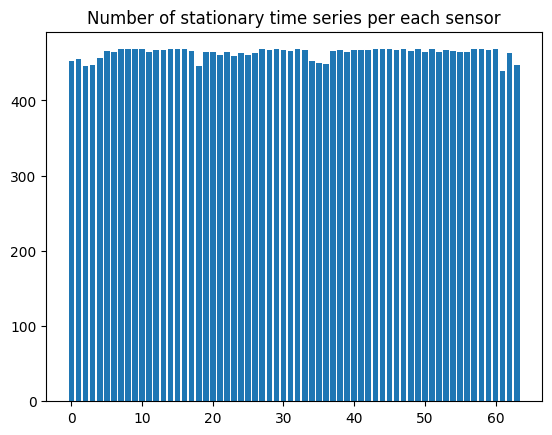

In [176]:
stationary_ts = np.zeros(data["Data1.csv"]["ts"].shape[1], dtype=int)

for d in data.values():
    for i_c, col in enumerate(d["ts"].columns):
        stationary_ts[i_c] += int(adfuller(d["ts"][col][1:] - np.roll(d["ts"][col][:-1], 1))[1] < 0.05)

plt.bar(range(len(stationary_ts)), stationary_ts)
plt.title("Number of stationary time series per each sensor")
plt.show()

# Baseline

In [247]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X = np.hstack((min_, mean_, max_))
y = classes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
print(model.score(X_test, y_test))
print(f1_score(y_test, model.predict(X_test)))

0.9419354838709677
0.9426751592356688
